In [2]:
!pip install timm

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tabulate import tabulate
import timm  # Import timm after installation
import csv

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Set paths for dataset splits
train_dir = 'I:/RICE/final_rice_data/train'
val_dir = 'I:/RICE/final_rice_data/val'
test_dir = 'I:/RICE/final_rice_data/test'

In [6]:
# Function to count images in a directory
def count_images_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each directory
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

# Display the counts
print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the validation set: {val_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 10000
Total number of images in the validation set: 1250
Total number of images in the test set: 1250


In [7]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(20),            # Random rotation
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

In [8]:
# Normalization for validation and test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [10]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Define the Xception model architecture
class XceptionModel(nn.Module):
    def __init__(self, num_classes):
        super(XceptionModel, self).__init__()
        self.xception = timm.create_model('xception', pretrained=True)  # Load Xception with pretrained weights
        self.xception.fc = nn.Linear(self.xception.get_classifier().in_features, num_classes)  # Modify the last layer

    def forward(self, x):
        return self.xception(x)

num_classes = 5  # Number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XceptionModel(num_classes).to(device)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [12]:
# Display model summary
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 128, 147, 147]               0
      BatchNorm2d-10        [-1, 128, 147, 147]             256
             ReLU-11        [-1, 128, 147, 147]               0
           Conv2d-12        [-1, 128, 147, 147]           1,152
           Conv2d-13        [-1, 128, 147, 147]          16,384
  SeparableConv2d-14        [-1, 128, 1

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [14]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc= "Training", leave = False):
        images, labels = images.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

    train_loss = running_loss / len(train_loader)  # Average loss
    train_accuracy = 100*correct / total  # Accuracy
    return train_loss, train_accuracy

In [15]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [16]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []  # To store training accuracy

    best_val_accuracy = 0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Append to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)  # Store training accuracy

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Accuracy: {train_accuracy:.4f} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation Loss: {val_loss:.4f}")

        # Check if we have a new best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_crack_detection_model.pth')
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}%")
        else:
            epochs_without_improvement += 1
        
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch + 1}.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [17]:
# Train and evaluate the model
num_epochs = 40
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/40 - Training Accuracy: 73.6800 - Training Loss: 0.9320 - Validation Accuracy: 90.4000 - Validation Loss: 0.4268
Best model saved with accuracy: 90.4000%


Epoch 2/40 - Training Accuracy: 93.0300 - Training Loss: 0.2792 - Validation Accuracy: 96.9600 - Validation Loss: 0.1453
Best model saved with accuracy: 96.9600%


Epoch 3/40 - Training Accuracy: 95.3900 - Training Loss: 0.1601 - Validation Accuracy: 97.2000 - Validation Loss: 0.1051
Best model saved with accuracy: 97.2000%


Epoch 4/40 - Training Accuracy: 96.2300 - Training Loss: 0.1253 - Validation Accuracy: 98.0800 - Validation Loss: 0.0829
Best model saved with accuracy: 98.0800%


Epoch 5/40 - Training Accuracy: 97.1800 - Training Loss: 0.1007 - Validation Accuracy: 98.1600 - Validation Loss: 0.0796
Best model saved with accuracy: 98.1600%


Epoch 6/40 - Training Accuracy: 97.5000 - Training Loss: 0.0857 - Validation Accuracy: 98.4000 - Validation Loss: 0.0445
Best model saved with accuracy: 98.4000%


Epoch 7/40 - Training Accuracy: 97.6900 - Training Loss: 0.0813 - Validation Accuracy: 98.5600 - Validation Loss: 0.0449
Best model saved with accuracy: 98.5600%


Epoch 8/40 - Training Accuracy: 98.0400 - Training Loss: 0.0662 - Validation Accuracy: 98.7200 - Validation Loss: 0.0395
Best model saved with accuracy: 98.7200%


Epoch 9/40 - Training Accuracy: 98.0000 - Training Loss: 0.0630 - Validation Accuracy: 98.8800 - Validation Loss: 0.0398
Best model saved with accuracy: 98.8800%


Epoch 10/40 - Training Accuracy: 98.4900 - Training Loss: 0.0533 - Validation Accuracy: 98.8800 - Validation Loss: 0.0325


Epoch 11/40 - Training Accuracy: 98.3000 - Training Loss: 0.0561 - Validation Accuracy: 98.4000 - Validation Loss: 0.0553


Epoch 12/40 - Training Accuracy: 98.4400 - Training Loss: 0.0511 - Validation Accuracy: 98.4800 - Validation Loss: 0.0395


Epoch 13/40 - Training Accuracy: 98.5800 - Training Loss: 0.0467 - Validation Accuracy: 98.9600 - Validation Loss: 0.0348
Best model saved with accuracy: 98.9600%


Epoch 14/40 - Training Accuracy: 98.6100 - Training Loss: 0.0425 - Validation Accuracy: 98.3200 - Validation Loss: 0.0590


Epoch 15/40 - Training Accuracy: 98.8200 - Training Loss: 0.0387 - Validation Accuracy: 98.5600 - Validation Loss: 0.0413


Epoch 16/40 - Training Accuracy: 98.8200 - Training Loss: 0.0395 - Validation Accuracy: 98.7200 - Validation Loss: 0.0390


Epoch 17/40 - Training Accuracy: 99.0500 - Training Loss: 0.0304 - Validation Accuracy: 99.0400 - Validation Loss: 0.0268
Best model saved with accuracy: 99.0400%


Epoch 18/40 - Training Accuracy: 98.8400 - Training Loss: 0.0353 - Validation Accuracy: 99.3600 - Validation Loss: 0.0253
Best model saved with accuracy: 99.3600%


Epoch 19/40 - Training Accuracy: 99.0200 - Training Loss: 0.0308 - Validation Accuracy: 99.0400 - Validation Loss: 0.0313


Epoch 20/40 - Training Accuracy: 98.9800 - Training Loss: 0.0341 - Validation Accuracy: 98.8000 - Validation Loss: 0.0454


Epoch 21/40 - Training Accuracy: 99.1100 - Training Loss: 0.0282 - Validation Accuracy: 98.7200 - Validation Loss: 0.0694


Epoch 22/40 - Training Accuracy: 98.9700 - Training Loss: 0.0292 - Validation Accuracy: 99.0400 - Validation Loss: 0.0379


Epoch 23/40 - Training Accuracy: 99.3100 - Training Loss: 0.0243 - Validation Accuracy: 99.6000 - Validation Loss: 0.0174
Best model saved with accuracy: 99.6000%


Epoch 24/40 - Training Accuracy: 99.0800 - Training Loss: 0.0278 - Validation Accuracy: 99.2800 - Validation Loss: 0.0369


Epoch 25/40 - Training Accuracy: 99.2500 - Training Loss: 0.0256 - Validation Accuracy: 99.1200 - Validation Loss: 0.0425


Epoch 26/40 - Training Accuracy: 99.3600 - Training Loss: 0.0204 - Validation Accuracy: 99.3600 - Validation Loss: 0.0243


Epoch 27/40 - Training Accuracy: 99.3400 - Training Loss: 0.0247 - Validation Accuracy: 99.2800 - Validation Loss: 0.0263


Epoch 28/40 - Training Accuracy: 99.4000 - Training Loss: 0.0202 - Validation Accuracy: 98.8800 - Validation Loss: 0.0731
Early stopping triggered. Stopping training at epoch 28.


In [18]:
# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0576, Test Accuracy: 98.72%


In [19]:
# Save accuracy and loss to a CSV file
with open('Xception_training_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])
    for epoch in range(len(train_losses)):  # Use len(train_losses) instead of num_epochs
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])

print("Training results saved to Xception_training_results.csv")

Training results saved to Xception_training_results.csv


In [20]:
# Optionally save the final model (this is optional since best model is already saved)
torch.save(model.state_dict(), 'xception_rice_model.pth')
print("Model training complete and saved as 'xception_rice_model.pth'.")

Model training complete and saved as 'xception_rice_model.pth'.


Training curves saved to xception_training_curves.png


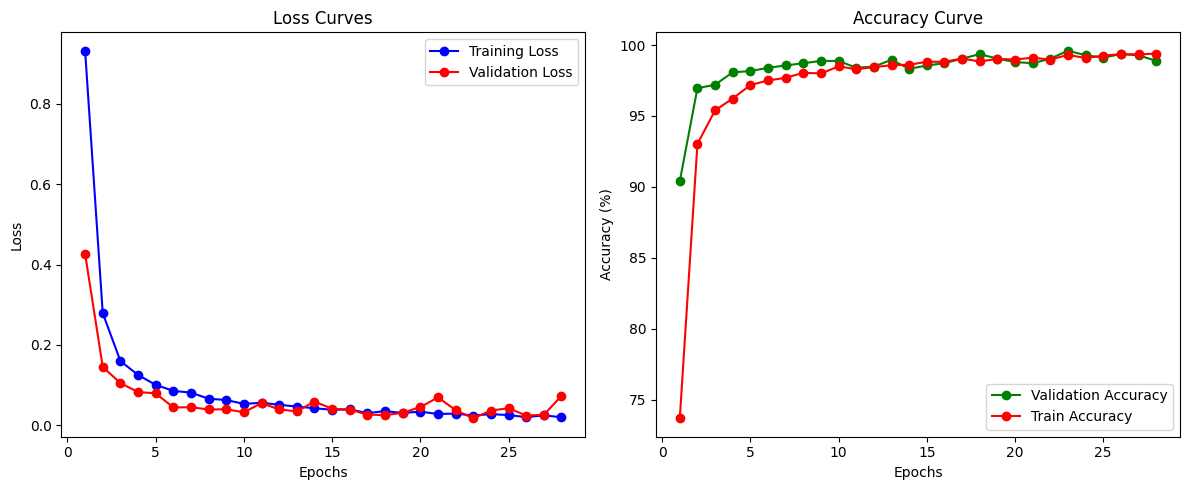

In [21]:
# Plotting accuracy and loss curves
def plot_curves(train_losses, val_losses, val_accuracies, train_accuracies, save_path="xception_training_curves.png"):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Training curves saved to {save_path}")
    plt.show()

# Call the function to plot the curves
plot_curves(train_losses, val_losses, val_accuracies, train_accuracies, save_path="xception_training_curves.png")